<a href="https://colab.research.google.com/github/manmeet3/Deep_Learning2/blob/master/Asg2/C_mixup_lbl_smoothing_cutout_tta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

C. Write a colab to demonstrate the mixup, label smoothing, cutout  and test time augmentation with proper ablation studies on a small data set (cifar? etc.,,.) - check slides for hints. you can use fastai. 

In [1]:
!pip install fastai --upgrade

     |████████████████████████████████| 358kB 4.4MB/s 
     |████████████████████████████████| 40kB 6.0MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [14]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import cv2
import datetime
import pandas as pd
import time
import h5py
import csv

import numpy
import matplotlib.pyplot as plt

In [3]:
#export
from fastai.basics import *
from fastai.callback.progress import *
from fastai.vision.core import *
from fastai.vision.models.xresnet import *

from torch.distributions.beta import Beta

Mixup

In [4]:
# https://docs.fast.ai/callback.mixup
# https://docs.fast.ai/data.core#Datasets
# https://colab.research.google.com/github/fastai/fastai/blob/master/nbs/19_callback.mixup.ipynb#scrollTo=detfFmUG_YUt

In [5]:
# export
@log_args
class MixUp(Callback):
    run_after,run_valid = [Normalize],False
    def __init__(self, alpha=0.4): self.distrib = Beta(tensor(alpha), tensor(alpha))
    def before_fit(self):
        self.stack_y = getattr(self.learn.loss_func, 'y_int', False)
        if self.stack_y: self.old_lf,self.learn.loss_func = self.learn.loss_func,self.lf

    def after_fit(self):
        if self.stack_y: self.learn.loss_func = self.old_lf

    def before_batch(self):
        lam = self.distrib.sample((self.y.size(0),)).squeeze().to(self.x.device)
        lam = torch.stack([lam, 1-lam], 1)
        self.lam = lam.max(1)[0]
        shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
        xb1,self.yb1 = tuple(L(self.xb).itemgot(shuffle)),tuple(L(self.yb).itemgot(shuffle))
        nx_dims = len(self.x.size())
        self.learn.xb = tuple(L(xb1,self.xb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=nx_dims-1)))
        if not self.stack_y:
            ny_dims = len(self.y.size())
            self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))

    def lf(self, pred, *yb):
        if not self.training: return self.old_lf(pred, *yb)
        with NoneReduce(self.old_lf) as lf:
            loss = torch.lerp(lf(pred,*self.yb1), lf(pred,*yb), self.lam)
        return reduce_loss(loss, getattr(self.old_lf, 'reduction', 'mean'))

In [24]:
path = untar_data(URLs.CIFAR_100)
items = get_image_files(path)

In [26]:
items

(#60000) [Path('/root/.fastai/data/cifar100/train/medium_mammals/porcupine/porcupine_s_000442.png'),Path('/root/.fastai/data/cifar100/train/medium_mammals/porcupine/hedgehog_s_000476.png'),Path('/root/.fastai/data/cifar100/train/medium_mammals/porcupine/hedgehog_s_000038.png'),Path('/root/.fastai/data/cifar100/train/medium_mammals/porcupine/hedgehog_s_000658.png'),Path('/root/.fastai/data/cifar100/train/medium_mammals/porcupine/porcupine_s_000119.png'),Path('/root/.fastai/data/cifar100/train/medium_mammals/porcupine/porcupine_s_000243.png'),Path('/root/.fastai/data/cifar100/train/medium_mammals/porcupine/hedgehog_s_000188.png'),Path('/root/.fastai/data/cifar100/train/medium_mammals/porcupine/porcupine_s_000049.png'),Path('/root/.fastai/data/cifar100/train/medium_mammals/porcupine/porcupine_s_000741.png'),Path('/root/.fastai/data/cifar100/train/medium_mammals/porcupine/hedgehog_s_001522.png')...]

In [13]:
path

Path('/root/.fastai/data/cifar100')

In [39]:
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]])
dls = tds.dataloaders(after_item=[ToTensor(), IntToFloatTensor()])

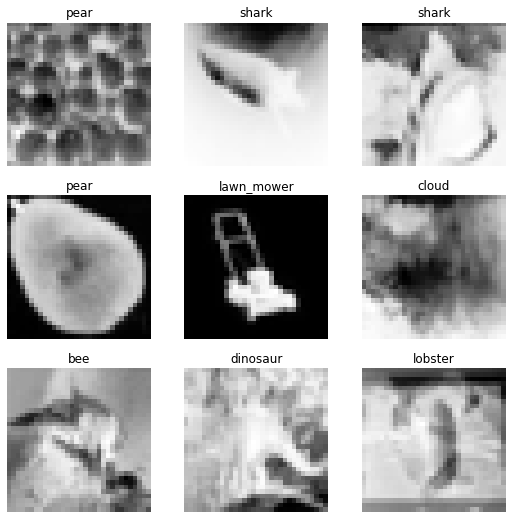

In [40]:
mixup = MixUp(0.5)
with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup) as learn:
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')

_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(mixup.x,mixup.y), ctxs=axs.flatten())

Label Smoothing

Cutout

Test Time Augmentation